In [1]:
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.nn.init as init

import random

import pandas as pd
import wandb

from src.CPPN1 import CPPN1
from sklearn.model_selection import train_test_split

In [2]:
# wandb.init(project="CPPNsquared")

#### Hyperparameters

In [3]:
device = 'cuda'
num_steps = 400
batch_size = 8512
learn_rate = 0.001
momentum = 0.9
num_channels = 3
image_shape = (512, 644)

In [4]:
cppn1 = CPPN1()
cppn1.load_state_dict = torch.load('CPPN64.pt')
print(cppn1)
# feature maps trasfer learning 

CPPN1(
  (fc1): Linear(in_features=2, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fce1): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=3, bias=True)
)


In [5]:
# def weights_initialized_randomly(model):
#     for name, param in model.named_parameters():
#         # Check if parameter is trainable and requires gradients
#         if param.requires_grad:
#             # If any parameter has non-zero values, it's not randomly initialized
#             if torch.sum(param.data) != 0:
#                 return False
#     return True

# print(weights_initialized_randomly(cppn1))

#### Map spacial coordinates

In [6]:
parameter_info = []
fc1 = []
full_coords = []
full_weights = []

def normalize_minus1_to_1(tensor):
    min_vals, _ = torch.min(tensor, dim=0)
    max_vals, _ = torch.max(tensor, dim=0)
    normalized_tensor = 2 * (tensor - min_vals) / (max_vals - min_vals) - 1
    return normalized_tensor

def spatial_coords(array, layer):

    coords = []
    row1 = []
    row2 = []
    for i in range(array.shape[0]):
        row2.append([layer+1, i])
    for i in range(array.shape[1]):
        row1.append([layer, i])
            
    array = array.flatten("C").tolist()
    # print(array)
    for i in row2:
        for j in row1:
            temp = []
            temp.extend(j)
            temp.extend(i)
            coords.append((temp))
    # coords_array = np.array(coords)
    # coords_array.astype(int)
    # output = np.column_stack((coords_array, array))

    # print(len(output))
    return coords, array
            
    # array.flatten()
    # return np.stack((array, coords))

index = 0
for name, param in cppn1.named_parameters():
    
    # print(name)
    if name.endswith(".weight"):
        
        # print(index)
        # print(param)
        temp_layer = param.detach().numpy() # need to learn more about gradients and why they are required
        # print(temp_layer)

        temp_coords, temp_weights = spatial_coords(temp_layer, index)
        temp_coords = torch.tensor(temp_coords, device=device, dtype=torch.float32)
    
        normal = normalize_minus1_to_1(temp_coords)
        normal = torch.nan_to_num(normal, nan = 0)
        if index == 2:
            print(temp_coords)
            # print(normal)
        full_coords.extend(normal.tolist())
        full_weights.extend(temp_weights)

        index += 1
        # print(fc1.shape[0])

print(full_coords)
# print(full_weights)
    
# layer1_coords, layer1_weights = spatial_coords(fce1, 2)

# print(layer1_arragned)
    
    # getting seemingly random output here 
        

tensor([[ 2.,  0.,  3.,  0.],
        [ 2.,  1.,  3.,  0.],
        [ 2.,  2.,  3.,  0.],
        ...,
        [ 2., 61.,  3., 63.],
        [ 2., 62.,  3., 63.],
        [ 2., 63.,  3., 63.]], device='cuda:0')
[[0.0, -1.0, 0.0, -1.0], [0.0, 1.0, 0.0, -1.0], [0.0, -1.0, 0.0, -0.9682539701461792], [0.0, 1.0, 0.0, -0.9682539701461792], [0.0, -1.0, 0.0, -0.9365079402923584], [0.0, 1.0, 0.0, -0.9365079402923584], [0.0, -1.0, 0.0, -0.9047619104385376], [0.0, 1.0, 0.0, -0.9047619104385376], [0.0, -1.0, 0.0, -0.8730158805847168], [0.0, 1.0, 0.0, -0.8730158805847168], [0.0, -1.0, 0.0, -0.841269850730896], [0.0, 1.0, 0.0, -0.841269850730896], [0.0, -1.0, 0.0, -0.8095238208770752], [0.0, 1.0, 0.0, -0.8095238208770752], [0.0, -1.0, 0.0, -0.7777777910232544], [0.0, 1.0, 0.0, -0.7777777910232544], [0.0, -1.0, 0.0, -0.7460317611694336], [0.0, 1.0, 0.0, -0.7460317611694336], [0.0, -1.0, 0.0, -0.7142857313156128], [0.0, 1.0, 0.0, -0.7142857313156128], [0.0, -1.0, 0.0, -0.682539701461792], [0.0, 1.0, 0

#### Set up CPPN_squared

In [7]:
class CPPN_squared(nn.Module):
    
    def __init__(self):
      super(CPPN_squared, self).__init__()

      self.fc1 = nn.Linear(4, 16)

      self.fc2 = nn.Linear(16, 32)
      self.fce1 = nn.Linear(64, 64)
      self.fce2 = nn.Linear(64,64)

      self.fc3 = nn.Linear(16, 1)     

      self.init_weights()
      
    def init_weights(self):
      for m in self.modules():
          if isinstance(m, nn.Linear):
              # Initialize weights using Xavier initialization
              init.xavier_normal_(m.weight)
              # Initialize biases to zeros
              init.constant_(m.bias, 0)
    
    # defines forward pass
    def forward(self, x):

        x = self.fc1(x)
        x = F.relu(x)

        # x = self.fc2(x)
        # x = F.relu(x)

        # x = self.fce1(x)
        # x = F.relu(x)

        # x = self.fce2(x)
        # x = F.relu(x)

        x = self.fc3(x)
        # x = F.sigmoid(x)

        # returns the output of layer 3 after activation
        return x

In [8]:
CPPN_squared = CPPN_squared()
# wandb.watch(CPPN_squared)
CPPN_squared.to(device)
CPPN_squared.requires_grad_()

# optimiser = torch.optim.SGD(cppn.parameters(), lr=learn_rate, momentum=momentum)
optimiser = torch.optim.Adam(CPPN_squared.parameters(), lr=learn_rate)



criterion = nn.MSELoss(reduction='mean')
# criterion = nn.L1Loss(reduction = "mean")
# criterion = nn.CrossEntropyLoss(reduction='sum')

#### Normalization

In [9]:
def normalize_minus1_to_1(tensor):
    min_vals, _ = torch.min(tensor, dim=0)
    max_vals, _ = torch.max(tensor, dim=0)
    normalized_tensor = 2 * (tensor - min_vals) / (max_vals - min_vals) - 1
    return normalized_tensor

In [10]:
normalized_coords_matrix = torch.tensor(full_coords, device=device, dtype=torch.float32)

# Normalize the coordinates matrix along each column
# normalized_coords_matrix = normalize_minus1_to_1(all_xy_coordinates)
# print(normalized_coords_matrix)

all_pixel_values = torch.tensor(full_weights, device=device, dtype=torch.float32)
all_pixel_values = (all_pixel_values + 1)/2
# all_pixel_values = torch.unsqueeze(all_pixel_values, 0)
print(all_pixel_values)

tensor([0.3407, 0.3857, 0.3984,  ..., 0.4564, 0.5110, 0.4805], device='cuda:0')


#### Split training and validation set


In [11]:

# train, test = train_test_split(normalized_coords_matrix, test_size= 0.2, random_state=42)
train_coords, val_coords, train_pixel_values, val_pixel_values = train_test_split(normalized_coords_matrix, all_pixel_values, test_size=0.1, random_state=42)
# import math
batch_size = int(batch_size * 0.9)

In [12]:
print(normalized_coords_matrix)

tensor([[ 0.0000, -1.0000,  0.0000, -1.0000],
        [ 0.0000,  1.0000,  0.0000, -1.0000],
        [ 0.0000, -1.0000,  0.0000, -0.9683],
        ...,
        [ 0.0000,  0.9365,  0.0000,  1.0000],
        [ 0.0000,  0.9683,  0.0000,  1.0000],
        [ 0.0000,  1.0000,  0.0000,  1.0000]], device='cuda:0')


In [13]:
num_coords = normalized_coords_matrix.shape[0]
coord_indexes = list(range(0, num_coords))
losses = []
img_list = []
running_loss = 0.0
best_loss = 10000000
best_val_loss = 10000000

# training loop
for i in range(num_steps):
    optimiser.zero_grad()
    CPPN_squared.zero_grad()

    # Sample a random batch of indexes from the list coord_indexes
    training_batch_indexes = torch.tensor(np.array(random.sample(range(0, train_coords.shape[0]), batch_size)))
    
    # Get batch of respective xy_coordiantes
    training_coords_batch = normalized_coords_matrix[training_batch_indexes]
    
    # And respective pixel values 
    pixel_values_batch = train_pixel_values[training_batch_indexes]
    pixel_values_batch = pixel_values_batch.unsqueeze(1)
    
    # Process data with model
    approx_pixel_values = CPPN_squared(training_coords_batch)
    
    # Calculate and track loss function
    loss = criterion(pixel_values_batch, approx_pixel_values)
    running_loss += loss.item()
    losses.append(loss.item())
    
    if i % 1 == 0:
        if running_loss < best_loss:
            best_loss = running_loss
            torch.save(CPPN_squared.state_dict(), 'CPPN2model.pt')
        print(f'step {i}, loss {running_loss:.3f}')
        # wandb.log({"loss": loss.item()})
        running_loss = 0.0

        #validation loop
        with torch.no_grad():
            val_loss = 0.0
            #should i iterate through them one by one or just do the whole thing?
            # for i in range(val_coords.shape[0]):
            #     val_output = CPPN_squared(val_coords[i])
            #     val_loss += criterion(val_pixel_values[i], val_output.unsqueeze(0)).item()
            val_output = CPPN_squared(val_coords)
            val_loss += criterion(val_pixel_values.unsqueeze(1), val_output).item()
            # val_loss /= val_coords.shape[0]

            # if val_loss < best_val_loss:
            #     best_val_loss = val_loss
            #     best_model_weights = CPPN_squared.state_dict()
            #     torch.save(best_model_weights, 'best_CPPN2_weights.pt')
                
            print(f'Validation - Step {i}, loss {val_loss:.3f}')
            # wandb.log({"val_loss": val_loss})

            
    #Update model
    loss.backward()
    optimiser.step()
    # wandb.log({"final_weights": CPPN_squared.state_dict()})

step 0, loss 0.294
Validation - Step 0, loss 0.327
step 1, loss 0.288
Validation - Step 1, loss 0.321
step 2, loss 0.282
Validation - Step 2, loss 0.314
step 3, loss 0.276
Validation - Step 3, loss 0.308
step 4, loss 0.271
Validation - Step 4, loss 0.302
step 5, loss 0.265
Validation - Step 5, loss 0.296
step 6, loss 0.259
Validation - Step 6, loss 0.290
step 7, loss 0.254
Validation - Step 7, loss 0.284
step 8, loss 0.248
Validation - Step 8, loss 0.278
step 9, loss 0.243
Validation - Step 9, loss 0.272
step 10, loss 0.238
Validation - Step 10, loss 0.267
step 11, loss 0.233
Validation - Step 11, loss 0.261
step 12, loss 0.227
Validation - Step 12, loss 0.256
step 13, loss 0.222
Validation - Step 13, loss 0.250
step 14, loss 0.218
Validation - Step 14, loss 0.245
step 15, loss 0.213
Validation - Step 15, loss 0.240
step 16, loss 0.208
Validation - Step 16, loss 0.235
step 17, loss 0.203
Validation - Step 17, loss 0.230
step 18, loss 0.199
Validation - Step 18, loss 0.225
step 19, loss

In [14]:
with torch.no_grad():
    torch.set_printoptions(profile="full")
    prediction = CPPN_squared(normalized_coords_matrix)
    prediction = prediction.flatten(0)
    # prediction = prediction * 2 - 1
    print(prediction)

tensor([0.5720, 0.5343, 0.5669, 0.5318, 0.5619, 0.5292, 0.5568, 0.5267, 0.5517,
        0.5242, 0.5466, 0.5217, 0.5415, 0.5191, 0.5364, 0.5166, 0.5314, 0.5141,
        0.5263, 0.5117, 0.5212, 0.5094, 0.5202, 0.5072, 0.5193, 0.5049, 0.5182,
        0.5026, 0.5171, 0.5004, 0.5188, 0.4981, 0.5204, 0.4958, 0.5220, 0.4936,
        0.5237, 0.4972, 0.5253, 0.5008, 0.5269, 0.5044, 0.5289, 0.5081, 0.5312,
        0.5117, 0.5336, 0.5153, 0.5359, 0.5189, 0.5382, 0.5225, 0.5405, 0.5261,
        0.5428, 0.5297, 0.5454, 0.5333, 0.5483, 0.5369, 0.5512, 0.5405, 0.5540,
        0.5441, 0.5569, 0.5478, 0.5598, 0.5514, 0.5626, 0.5550, 0.5655, 0.5586,
        0.5684, 0.5622, 0.5712, 0.5658, 0.5741, 0.5694, 0.5715, 0.5730, 0.5673,
        0.5766, 0.5630, 0.5802, 0.5588, 0.5825, 0.5546, 0.5782, 0.5503, 0.5746,
        0.5461, 0.5714, 0.5418, 0.5683, 0.5376, 0.5651, 0.5334, 0.5619, 0.5291,
        0.5588, 0.5249, 0.5556, 0.5207, 0.5524, 0.5164, 0.5492, 0.5122, 0.5461,
        0.5080, 0.5429, 0.5037, 0.5397, 

In [15]:
print(all_pixel_values)

tensor([0.3407, 0.3857, 0.3984, 0.3441, 0.4544, 0.6465, 0.6716, 0.3492, 0.7049,
        0.3092, 0.7562, 0.6661, 0.2337, 0.6674, 0.7616, 0.7342, 0.1501, 0.3293,
        0.8201, 0.6022, 0.6643, 0.3653, 0.5451, 0.8202, 0.2618, 0.8156, 0.8006,
        0.7740, 0.7932, 0.8525, 0.7951, 0.8225, 0.8240, 0.1905, 0.5751, 0.6409,
        0.4785, 0.3823, 0.6139, 0.3001, 0.2418, 0.3406, 0.2012, 0.7610, 0.2930,
        0.1781, 0.6273, 0.2649, 0.1571, 0.1848, 0.6651, 0.3570, 0.3940, 0.5335,
        0.4314, 0.4297, 0.2316, 0.1663, 0.3932, 0.4327, 0.5782, 0.4859, 0.1927,
        0.2368, 0.8485, 0.5047, 0.2440, 0.8316, 0.4680, 0.4372, 0.7126, 0.6904,
        0.5441, 0.5334, 0.3389, 0.7760, 0.2355, 0.3158, 0.5602, 0.2750, 0.2342,
        0.6885, 0.6928, 0.1759, 0.6897, 0.7782, 0.4516, 0.3141, 0.4963, 0.8342,
        0.3854, 0.2405, 0.5020, 0.4112, 0.6183, 0.1831, 0.5572, 0.6179, 0.3942,
        0.4456, 0.2214, 0.5988, 0.4232, 0.4156, 0.5611, 0.7660, 0.1541, 0.3590,
        0.2046, 0.5045, 0.2174, 0.6516, 

Text(0.5, 1.0, 'target')

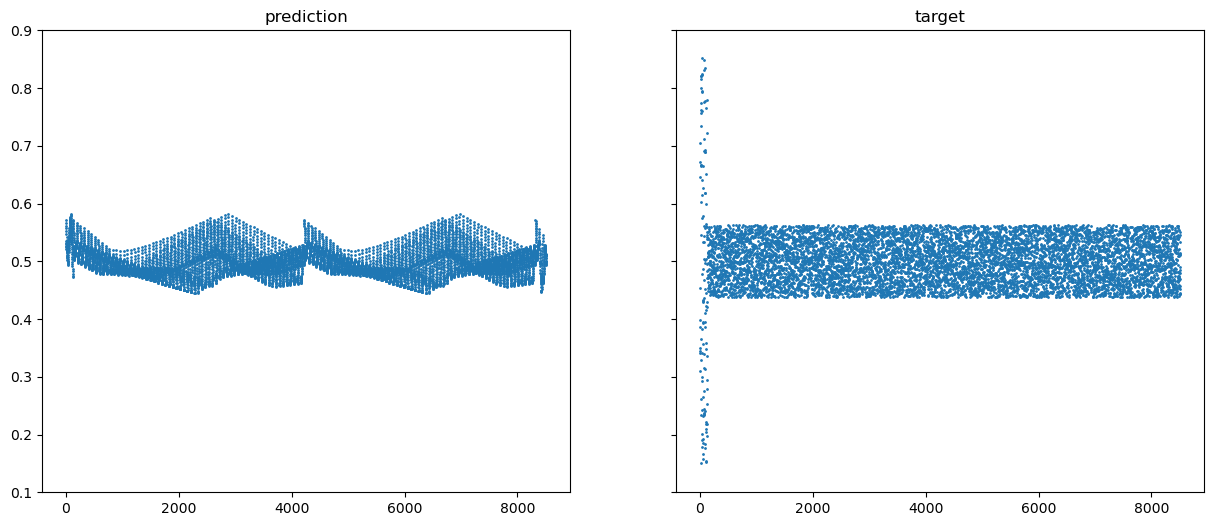

In [16]:
fig, ax = plt.subplots(1, 2, sharey=True, figsize = (15, 6))
ax[0].set_ylim([0.1, 0.9])
x_values = np.arange(len(prediction.cpu().numpy()))

ax[0].scatter(x_values, prediction.cpu().numpy(), marker='o', s=1)
ax[0].set_title("prediction")
ax[1].scatter(x_values, all_pixel_values.cpu().numpy(), marker='o', s=1)
ax[1].set_title("target")

In [17]:
prediction.mul_(2).sub_(1)
index_tracker = 0
with torch.no_grad():
    for name, param in cppn1.named_parameters():
        # print(name)
        if name.endswith(".weight"):
            # print(param) 
            temp_tensor = prediction[index_tracker:(index_tracker + param.numel())]
            print(param.numel())
            temp_tensor = torch.reshape(temp_tensor, param.shape)
            print(temp_tensor)
            param.data.copy_(temp_tensor)
            # print(param.numel())
            index_tracker += param.numel()
    
            print(f"{name} replacement complete")

    torch.save(cppn1.state_dict(), "CPPNsquared_output.pt")

128
tensor([[ 0.1440,  0.0686],
        [ 0.1339,  0.0636],
        [ 0.1237,  0.0585],
        [ 0.1135,  0.0534],
        [ 0.1034,  0.0484],
        [ 0.0932,  0.0433],
        [ 0.0830,  0.0383],
        [ 0.0729,  0.0332],
        [ 0.0627,  0.0281],
        [ 0.0526,  0.0234],
        [ 0.0424,  0.0189],
        [ 0.0404,  0.0143],
        [ 0.0386,  0.0098],
        [ 0.0363,  0.0053],
        [ 0.0342,  0.0007],
        [ 0.0375, -0.0038],
        [ 0.0408, -0.0084],
        [ 0.0441, -0.0128],
        [ 0.0473, -0.0055],
        [ 0.0506,  0.0017],
        [ 0.0539,  0.0089],
        [ 0.0578,  0.0161],
        [ 0.0625,  0.0233],
        [ 0.0671,  0.0305],
        [ 0.0717,  0.0378],
        [ 0.0764,  0.0450],
        [ 0.0810,  0.0522],
        [ 0.0857,  0.0594],
        [ 0.0909,  0.0666],
        [ 0.0966,  0.0739],
        [ 0.1023,  0.0811],
        [ 0.1081,  0.0883],
        [ 0.1138,  0.0955],
        [ 0.1195,  0.1027],
        [ 0.1252,  0.1100],
        [ 0.1310